In [233]:
import numpy as np
import pickle
import os
import sys
import itertools as it

import matplotlib.pyplot as plt
from SALib.sample import saltelli

import tqdm
import contextlib

sys.path.append('./GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

from UQpy.distributions import Normal, Uniform, JointIndependent

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [17]:
def PCE_LAR_model_selection(x, g, n_params, dist_obj, max_degree):
  
    n_dcoords = g.shape[1]
    
    # construct total-degree polynomial basis
    polynomial_basis = TotalDegreeBasis(dist_obj, max_degree)

    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    xx_train, xx_test, \
        gg_train, gg_test = train_test_split(x, g, train_size=2 / 3, random_state=1)

    error_pceLAR = np.zeros((n_dcoords))
    LOO_pceLAR   = np.zeros((n_dcoords))
    pceLAR_fo_si = np.zeros((n_params, n_dcoords))
    pceLAR_to_si = np.zeros((n_params, n_dcoords))

    for i in range(n_dcoords):
#         print('Theta',i)
        
        pce.fit(xx_train, gg_train[:, i])
        # Lars model selection
        print('Size of the full set of PCE basis:', polynomial_basis.polynomials_number)

        target_error = 1
        CheckOverfitting = True
        pceLAR = polynomial_chaos.regressions.LeastAngleRegression.model_selection(pce, 
                                                                                   target_error, 
                                                                                   CheckOverfitting)

        print('Size of the LAR PCE basis:', pceLAR.polynomial_basis.polynomials_number)

        error_pceLAR[i] = ErrorEstimation(surr_object=pceLAR).validation(xx_test, gg_test[:, i])           
        LOO_pceLAR[i]   = pceLAR.leaveoneout_error()

        print('Leave-one-out cross validation on ED:', pceLAR.leaveoneout_error())

        pceLAR_sensitivity = PceSensitivity(pceLAR)
        pceLAR_sensitivity.run()

        LAR_sobol_first = pceLAR_sensitivity.first_order_indices
        LAR_sobol_total = pceLAR_sensitivity.total_order_indices

        pceLAR_fo_si[:, i] = LAR_sobol_first.T
        pceLAR_to_si[:, i] = LAR_sobol_total.T
        
    return (error_pceLAR, LOO_pceLAR, pceLAR_fo_si, pceLAR_to_si)

In [18]:
# problem definition
PROBLEM = {
    "num_vars" : 6,
    "names"    : ["project_cost",
                  "gain_right",
                  "alpha_beta",
                  "prob_left",
                  "init_w_scale",
                  "poisson_scale"],
    "bounds"   : [[0.01, 2.00],
                  [1.70, 2.30],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [0.01, 0.15],
                  [8.00, 20.0]]
}
# generate Saltelli samples
NUM_SAMPLES = 1024
x = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)
print(f'Problem bounds: {PROBLEM["bounds"]}')


pdf1 = Uniform(loc=0.01, scale=1.99) 
pdf2 = Uniform(loc=1.70, scale=0.60)  
pdf3 = Uniform(loc=0.70, scale=0.10)  
pdf4 = Uniform(loc=0.30, scale=0.15)  
pdf5 = Uniform(loc=0.01, scale=0.14)  
pdf6 = Uniform(loc=8.00, scale=12.0)
margs = [pdf1, pdf2, pdf3, pdf4, pdf5, pdf6]
joint = JointIndependent(marginals=margs)

Problem bounds: [[0.01, 2.0], [1.7, 2.3], [0.7, 0.8], [0.3, 0.45], [0.01, 0.15], [8.0, 20.0]]


# Micro

In [50]:
micro_files = sorted([f for f in os.listdir("GDMAPS_results/") if "micro" in f])

d_coords = []
for f in micro_files:
    with open("GDMAPS_results/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])
    
n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(6, 3, 10)

In [51]:
s_max = [6, 12]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=x, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)
        
        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]
        
        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))
        
        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open("PCE_LAR_RESULTS_micro.pickle", "wb") as f:
            pickle.dump(RES, f)

Run: 0
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 286
Leave-one-out cross validation on ED: 0.0030073
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 254
Leave-one-out cross validation on ED: 0.0147998
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 198
Leave-one-out cross validation on ED: 0.0087234
--- PCE-LAR took 153.49882173538208 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 332
Leave-one-out cross validation on ED: 0.0021251
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 274
Leave-one-out cross validation on ED: 0.0093433
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 318
Leave-one-out cross validation on ED: 0.0056339
--- PCE-LAR took 586.7554819583893 seconds ---
Run: 1
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 210
Leave-one-out cross validation 

Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 300
Leave-one-out cross validation on ED: 0.0027156
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 447
Leave-one-out cross validation on ED: 0.0071768
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 450
Leave-one-out cross validation on ED: 0.0062522
--- PCE-LAR took 875.0059571266174 seconds ---


# Meso

In [263]:
meso_files = sorted([f for f in os.listdir("GDMAPS_results/") if "meso" in f])

d_coords = []
for f in meso_files:
    with open("GDMAPS_results/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])

n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(6, 3, 10)

In [264]:
s_max = [6, 12]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=x, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)

        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]

        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))

        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open("PCE_LAR_RESULTS_meso.pickle", "wb") as f:
            pickle.dump(RES, f)

Run: 0
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 146
Leave-one-out cross validation on ED: 0.0047474
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 201
Leave-one-out cross validation on ED: 0.0172286
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 172
Leave-one-out cross validation on ED: 0.0101909
--- PCE-LAR took 72.68655920028687 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 262
Leave-one-out cross validation on ED: 0.0038422
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 322
Leave-one-out cross validation on ED: 0.0130767
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 251
Leave-one-out cross validation on ED: 0.0072905
--- PCE-LAR took 539.6307320594788 seconds ---
Run: 1
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 222
Leave-one-out cross validation o

Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 313
Leave-one-out cross validation on ED: 0.0048507
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 275
Leave-one-out cross validation on ED: 0.0066699
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 347
Leave-one-out cross validation on ED: 0.0125142
--- PCE-LAR took 572.1780247688293 seconds ---


# Global

In [265]:
global_files = sorted([f for f in os.listdir("GDMAPS_results/") if "global" in f])

d_coords = []
for f in global_files:
    with open("GDMAPS_results/" + f, "rb") as f:
        _, _, _, g_diff_runs, _, _ = pickle.load(f)
    d_coords.append(g_diff_runs[0])
    
n_params = X.shape[1]
n_dcoords = d_coords[0].shape[1]
n_runs = len(d_coords)
n_params, n_dcoords, n_runs

(6, 3, 10)

In [266]:
s_max = [6, 12]

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(n_runs):
    print("Run:", run)
    g = d_coords[run]

    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)

        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=x, 
                                             g=g, 
                                             n_params=n_params, 
                                             dist_obj=joint, 
                                             max_degree=s)
        
        LAR_fo_si[run, i] = LAR_result[2]
        LAR_to_si[run, i] = LAR_result[3]
        LAR_error[run, i] = LAR_result[0]
        LAR_LOO[run, i]   = LAR_result[1]
        
        print("--- PCE-LAR took %s seconds ---" % (time.time() - start_time))
        
        RES = [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO]
        with open("PCE_LAR_RESULTS_global.pickle", "wb") as f:
            pickle.dump(RES, f)

Run: 0
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 163
Leave-one-out cross validation on ED: 0.0246277
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 193
Leave-one-out cross validation on ED: 0.3342151
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 180
Leave-one-out cross validation on ED: 0.2091543
--- PCE-LAR took 87.55606603622437 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 388
Leave-one-out cross validation on ED: 0.0121098
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 282
Leave-one-out cross validation on ED: 0.2135605
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 405
Leave-one-out cross validation on ED: 0.1129611
--- PCE-LAR took 684.9114639759064 seconds ---
Run: 1
Max polynomial degree: 6
Size of the full set of PCE basis: 924
Size of the LAR PCE basis: 165
Leave-one-out cross validation o

Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 230
Leave-one-out cross validation on ED: 0.0279342
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 287
Leave-one-out cross validation on ED: 0.2000297
Size of the full set of PCE basis: 18564
Size of the LAR PCE basis: 376
Leave-one-out cross validation on ED: 0.3973949
--- PCE-LAR took 506.0295219421387 seconds ---


# Plot results

In [255]:
with open("PCE_LAR_RESULTS_micro.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)

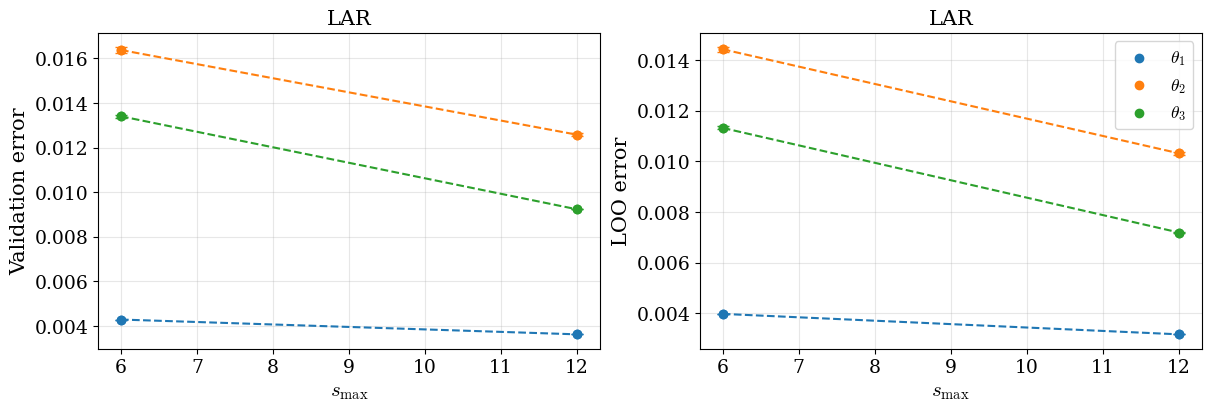

In [256]:
param_names = ["project_cost", "gain_right", "alpha_beta", "prob_left", "init_w_scale", "poisson_scale"]

n_dcoords = 3

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for d in range(n_dcoords):
    
    axs[0].scatter(s_max, LAR_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0].errorbar(s_max, LAR_error.mean(axis=0)[:, d],
                      LAR_error.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[1].scatter(s_max, LAR_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1].errorbar(s_max, LAR_LOO.mean(axis=0)[:, d],
                      LAR_LOO.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0].set(title=r"LAR")
    axs[1].set(title=r"LAR")
    
    
for i in range(3):
    axs[0].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[1].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

plt.legend()
plt.show()

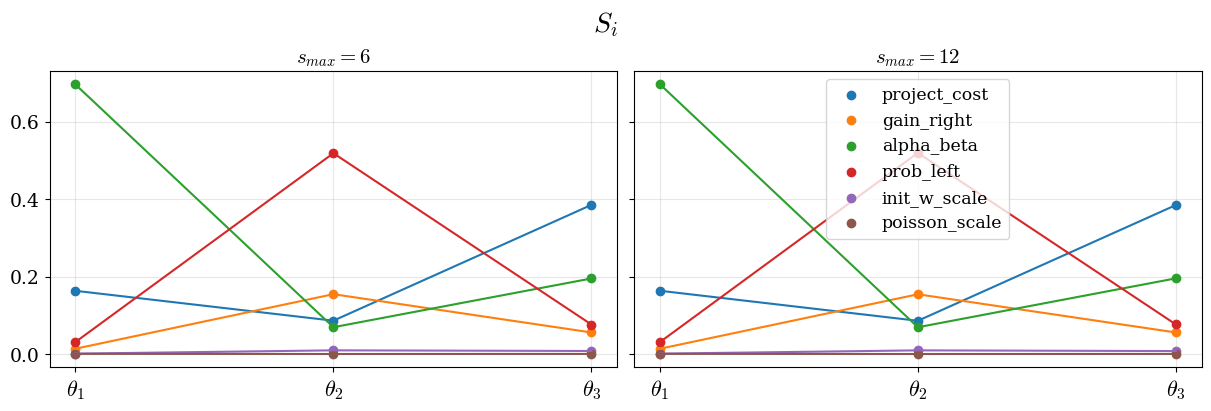

In [257]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharey=True)

for i, param in enumerate(param_names):
    
    axs[0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i])
    axs[0].plot([1,2,3],LAR_fo_si.mean(axis=0)[0][i])
    axs[0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[0].set_title(r"$s_{max}=6$")
    
    axs[1].scatter([1,2,3],LAR_fo_si.mean(axis=0)[1][i], label=param_names[i])
    axs[1].plot([1,2,3],LAR_fo_si.mean(axis=0)[1][i])
    axs[1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[1].set_title(r"$s_{max}=12$")
    axs[1].legend()
    
plt.suptitle(r"$S_i$", fontsize=20)
plt.show()

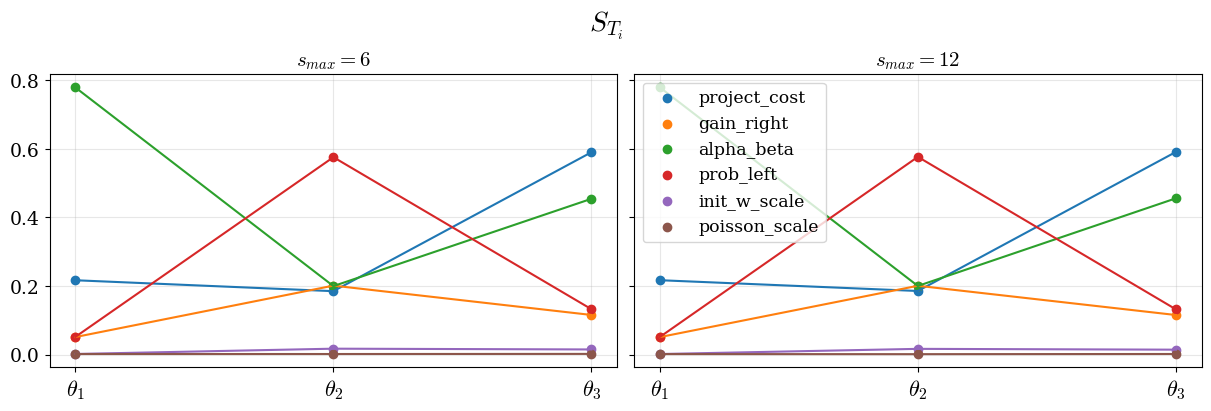

In [258]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharey=True)

for i, param in enumerate(param_names):
    
    axs[0].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i])
    axs[0].plot([1,2,3],LAR_to_si.mean(axis=0)[0][i])
    axs[0].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[0].set_title(r"$s_{max}=6$")

    axs[1].scatter([1,2,3],LAR_to_si.mean(axis=0)[1][i], label=param_names[i])
    axs[1].plot([1,2,3],LAR_to_si.mean(axis=0)[1][i])
    axs[1].set_xticks([1,2,3], labels=[rf"$\theta_{i}$" for i in range(1,4)], fontsize=16)
    axs[1].set_title(r"$s_{max}=12$")
    axs[1].legend()
    
plt.suptitle(r"$S_{T_i}$", fontsize=20)
plt.show()